In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import metpy.calc as mpcalc
from metpy.plots import Hodograph
from metpy.units import units
from matplotlib.cm import get_cmap
import re


In [9]:
rawData = './T3_1800_12132020_Artemis_Rerun.txt'

In [10]:

#Grab header information such as station name date etc...
def headerData(rawData, encoding='ISO-8859-1'):
    start_line = None
    end_line = None
    with open(rawData, 'r', encoding=encoding) as file:
        headerDataHit = False
        for i, line in enumerate(file):
            if 'Launch Date:' in line:
                headerDataHit = True
            elif headerDataHit and 'Profile Data:' in line:
                end_line = i 
                break
            elif headerDataHit and line.strip() and start_line is None:
                #Grabs line where profile data exists
                start_line = i  - 1
    return start_line, end_line
                
    
#Grab profile data which is what contains the raw Radiosonde data
def grabProfileData(rawData, encoding='ISO-8859-1'):
    start_line = None
    end_line = None
    with open(rawData, 'r', encoding=encoding) as file:
        pfDataHit = False
        for i, line in enumerate(file):
            if 'Profile Data' in line:
                pfDataHit = True
            elif pfDataHit and 'Tropopauses:' in line:
                #Mark the line before Tropopauses footer
                end_line = i - 1
                break
            elif pfDataHit and line.strip() and start_line is None:
                #Grabs line where profile data exists
                start_line = i
    return start_line, end_line
    
    
# #Grab troposphere data which is at the footer of the file
# def tropoData(rawData, encoding='ISO-8859-1'):
#     start_line = None
#     end_line = None
#     with open(rawData, 'r', encoding=encoding) as file:
#         tropoDataHit = False
#         for i, line in enumerate(file):
#             if '1. Tropopause:' in line:
#                 tropoDataHit = True
#             elif tropoDataHit and 'Reason of Stop Sounding:' in line:
#                 end_line = i 
#                 break
#             elif tropoDataHit and line.strip() and start_line is None:
#                 #Grabs line where profile data exists
#                 start_line = i -1
#     return start_line, end_line
                
    

In [16]:
data_start_line, data_end_line = headerData(rawData)
if data_start_line is not None and data_end_line is not None:
    nrows_to_read = data_end_line - data_start_line
    header_df = pd.read_csv(rawData, sep='\t', skiprows=data_start_line, nrows=nrows_to_read, engine='python', encoding='ISO-8859-1', header=None)

data_start_line, data_end_line = grabProfileData(rawData)
if data_start_line is not None and data_end_line is not None:
    nrows_to_read = data_end_line - data_start_line
    profile_df = pd.read_csv(rawData, sep='\t', skiprows=data_start_line, nrows=nrows_to_read, engine='python', encoding='ISO-8859-1')
    #profile_df.columns += profile_df.iloc[0]
    profile_df.rename(columns=lambda x: x.strip(), inplace=True)
    profile_df = profile_df[1:]


# data_start_line, data_end_line = tropoData(rawData)
# if data_start_line is not None and data_end_line is not None:
#     nrows_to_read = data_end_line - data_start_line
#     tropo_df = pd.read_csv(rawData, sep='\t', skiprows=data_start_line, nrows=nrows_to_read, engine='python', encoding='ISO-8859-1')
    
def get_tropopause_value(file_path):
    with open(file_path, 'r', encoding='ISO-8859-1') as file:
        lines = file.readlines()
        tropopause_found = False 
        for i, line in enumerate(lines):
            if "Tropopauses:" in line:
                tropopause_found = True  
            if tropopause_found and "1.:" in line:
                value = line.split("1.:")[1].split()[0]
                return float(value)
                break 

In [19]:
#Converts column to whatever integer equivalent float / int
for col in profile_df.select_dtypes(include=['object']).columns:
    profile_df[col] = pd.to_numeric(profile_df[col], downcast='integer')
    
mean_temp = profile_df['T'].mean()
profile_df['T_Perturbation'] = profile_df['T'] - mean_temp
    
Tropopause = get_tropopause_value(rawData)
closest_index = (profile_df['P'] - Tropopause).abs().idxmin()
tropo_df = profile_df.iloc[:closest_index + 1]
strato_df = profile_df.iloc[closest_index + 1:]
    
#Calculates the difference between followings alts
profile_df['Ascending_Rate'] = profile_df['Alt'].diff()
peak_index = profile_df[profile_df['Ascending_Rate'] < 0].first_valid_index()
#Drop rows after peak and drop diff column
if peak_index is not None:
    profile_df = profile_df.loc[:peak_index - 1]
tropo_df

,Time,P,T,Hu,Ws,Wd,Long.,Lat.,Alt,Geopot,MRI,RI,Dewp.,Virt. Temp,Rs,Elevation,Azimuth,Range,D,T_Perturbation
1,0,1024.5,16.8,58,4.9,198,-73.160400,-39.236410,3,3,277.234,276.763,8.5,18.0,0.0,39.2,180,0,1.231139,58.325243
2,1,1023.5,16.7,58,4.9,200,-73.160259,-39.236324,12,11,278.454,276.649,8.5,17.8,8.5,30.0,53,18,1.230524,58.225243
3,2,1022.5,16.5,59,5.0,201,-73.160118,-39.236238,20,20,279.659,276.535,8.5,17.7,8.5,29.3,52,35,1.229909,58.025243
4,3,1021.5,16.4,59,5.1,203,-73.159977,-39.236153,28,28,280.880,276.422,8.5,17.6,8.5,29.1,52,53,1.229295,57.925243
5,4,1020.4,16.2,60,5.1,204,-73.159836,-39.236067,37,37,282.086,276.308,8.4,17.4,8.5,29.0,52,70,1.228682,57.725243
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2286,2285,203.0,-62.4,64,31.3,218,-72.694329,-38.924746,11959,11930,1957.686,80.139,-65.5,-62.4,4.3,12.4,50,54513,0.335652,-20.874757
2287,2286,202.9,-62.4,64,31.3,218,-72.694077,-38.924529,11963,11934,1958.296,80.089,-65.5,-62.4,4.3,12.4,50,54546,0.335443,-20.874757
2288,2287,202.8,-62.4,64,31.3,219,-72.693825,-38.924312,11967,11938,1958.921,80.040,-65.6,-62.4,4.3,12.4,50,54578,0.335235,-20.874757
2289,2288,202.6,-62.4,64,31.4,219,-72.693574,-38.924096,11972,11942,1959.546,79.989,-65.6,-62.4,4.3,12.4,50,54611,0.335023,-20.874757


In [20]:
profile_df

,Time,P,T,Hu,Ws,Wd,Long.,Lat.,Alt,Geopot,...,RI,Dewp.,Virt. Temp,Rs,Elevation,Azimuth,Range,D,T_Perturbation,Ascending_Rate
1,0,1024.5,16.8,58,4.9,198,-73.160400,-39.236410,3,3,...,276.763,8.5,18.0,0.0,39.2,180,0,1.231139,58.325243,NaN
2,1,1023.5,16.7,58,4.9,200,-73.160259,-39.236324,12,11,...,276.649,8.5,17.8,8.5,30.0,53,18,1.230524,58.225243,9.0
3,2,1022.5,16.5,59,5.0,201,-73.160118,-39.236238,20,20,...,276.535,8.5,17.7,8.5,29.3,52,35,1.229909,58.025243,8.0
4,3,1021.5,16.4,59,5.1,203,-73.159977,-39.236153,28,28,...,276.422,8.5,17.6,8.5,29.1,52,53,1.229295,57.925243,8.0
5,4,1020.4,16.2,60,5.1,204,-73.159836,-39.236067,37,37,...,276.308,8.4,17.4,8.5,29.0,52,70,1.228682,57.725243,9.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5855,5854,10.8,-42.3,3,25.0,88,-72.714997,-38.780770,30867,30700,...,3.824,-69.3,-42.2,0.8,25.5,37,70846,0.016248,-0.774757,1.0
5856,5855,10.8,-42.3,3,25.0,88,-72.715295,-38.780780,30868,30701,...,3.823,-69.3,-42.2,0.8,25.5,37,70831,0.016246,-0.774757,1.0
5857,5856,10.8,-42.3,3,25.1,88,-72.715593,-38.780790,30868,30702,...,3.823,-69.3,-42.3,0.8,25.6,37,70816,0.016245,-0.774757,0.0
5858,5857,10.8,-42.3,3,25.1,88,-72.715891,-38.780799,30869,30703,...,3.822,-69.3,-42.3,0.8,25.6,37,70802,0.016244,-0.774757,1.0


In [44]:
def calcWindComps(dataframe,speeds, directions):
    speeds = np.array(dataframe[speeds])
    directions = np.array(dataframe[directions])
    
    u = -speeds * np.sin(np.radians(directions))
    v = -speeds * np.cos(np.radians(directions))
    dataframe['U'] = u
    dataframe['V'] = v
    return dataframe
profileComps = calcWindComps(profile_df, 'Ws', 'Wd')
tropoComps = calcWindComps(tropo_df, 'Ws', 'Wd')
stratoComps = calcWindComps(strato_df, 'Ws', 'Wd')

profile_df

/tmp/ipykernel_8236/2862690768.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['U'] = u
/tmp/ipykernel_8236/2862690768.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['V'] = v


,Time,P,T,Hu,Ws,Wd,Long.,Lat.,Alt,Geopot,...,Virt. Temp,Rs,Elevation,Azimuth,Range,D,T_Perturbation,Ascending_Rate,U,V
1,0,1024.5,16.8,58,4.9,198,-73.160400,-39.236410,3,3,...,18.0,0.0,39.2,180,0,1.231139,58.325243,NaN,1.514183,4.660177
2,1,1023.5,16.7,58,4.9,200,-73.160259,-39.236324,12,11,...,17.8,8.5,30.0,53,18,1.230524,58.225243,9.0,1.675899,4.604494
3,2,1022.5,16.5,59,5.0,201,-73.160118,-39.236238,20,20,...,17.7,8.5,29.3,52,35,1.229909,58.025243,8.0,1.791839,4.667902
4,3,1021.5,16.4,59,5.1,203,-73.159977,-39.236153,28,28,...,17.6,8.5,29.1,52,53,1.229295,57.925243,8.0,1.992729,4.694575
5,4,1020.4,16.2,60,5.1,204,-73.159836,-39.236067,37,37,...,17.4,8.5,29.0,52,70,1.228682,57.725243,9.0,2.074356,4.659082
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5855,5854,10.8,-42.3,3,25.0,88,-72.714997,-38.780770,30867,30700,...,-42.2,0.8,25.5,37,70846,0.016248,-0.774757,1.0,-24.984771,-0.872487
5856,5855,10.8,-42.3,3,25.0,88,-72.715295,-38.780780,30868,30701,...,-42.2,0.8,25.5,37,70831,0.016246,-0.774757,1.0,-24.984771,-0.872487
5857,5856,10.8,-42.3,3,25.1,88,-72.715593,-38.780790,30868,30702,...,-42.3,0.8,25.6,37,70816,0.016245,-0.774757,0.0,-25.084710,-0.875977
5858,5857,10.8,-42.3,3,25.1,88,-72.715891,-38.780799,30869,30703,...,-42.3,0.8,25.6,37,70802,0.016244,-0.774757,1.0,-25.084710,-0.875977


In [49]:
#XY graph choose x  y axis, poly degree, and labels
def graph2d(dataframe, x, y, deg, x_label, y_label, title, bestFit = True):
    plt.figure()
    plt.scatter(dataframe[x], dataframe[y], s=5, label='Data Points')

    #best fit curve
    coeffs = np.polyfit(dataframe[y], dataframe[x], deg)  
    y_curve = np.linspace(dataframe[y].min(), dataframe[y].max(), 500)  
    x_curve = np.polyval(coeffs, y_curve) 
    if bestFit == True:
        plt.plot(x_curve, y_curve, 'r-', label='Best Fit Line')
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.title(title)
    plt.legend()

    plt.show()

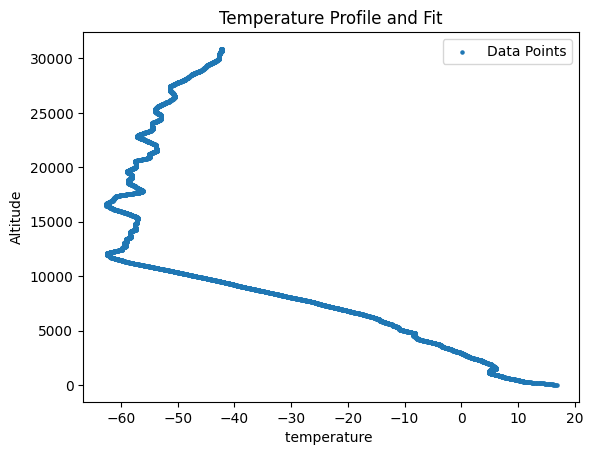

In [50]:
graph2d(profile_df, 'T','Alt' ,8,'temperature ', 'Altitude', 'Temperature Profile and Fit',False)

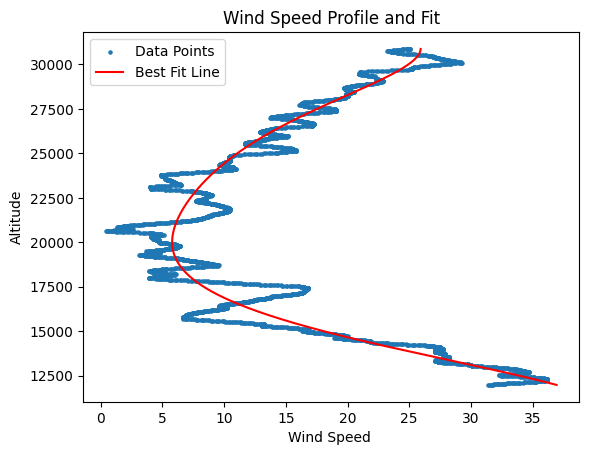

In [48]:
graph2d(strato_df, 'Ws','Alt' ,6,'Wind Speed ', 'Altitude', 'Wind Speed Profile and Fit')

In [45]:
def hodograph(compRange, lineWidth, dataframe,  alt_threshold):
    fig = plt.figure(figsize=(6, 6))
    ax = fig.add_subplot(1, 1, 1)
    hodo = Hodograph(ax, component_range=compRange)
    hodo.add_grid(increment=10)
    hodo.add_grid(increment=20, linestyle='-')
    alt_threshold_ = alt_threshold
    
    cmap = get_cmap('viridis')
    norm = plt.Normalize(vmin=profile_df['Alt'].min(), vmax=profile_df['Alt'].max())

    #plot the points and color them every 300m
    last_alt = profile_df['Alt'].iloc[0] - alt_threshold 
    for i in range(len(dataframe['U']) - 1):
        if profile_df['Alt'].iloc[i] >= last_alt + alt_threshold:
            segment_color = cmap(norm(profile_df['Alt'].iloc[i]))
            hodo.plot(dataframe['U'][i:i+2], dataframe['V'][i:i+2], color=segment_color, linewidth=lineWidth,
                      label=f'{profile_df["Alt"].iloc[i]:.0f}-{profile_df["Alt"].iloc[i+1]:.0f} m')
            last_alt = profile_df['Alt'].iloc[i]  

    #axis names and alt bar
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])
    cb = fig.colorbar(sm, ax=ax, orientation='vertical', fraction=0.046, pad=0.04)
    cb.set_label('Altitude (m)')
    ax.set_xlabel('U Component (m/s)')
    ax.set_ylabel('V Component (m/s)')
    plt.show()

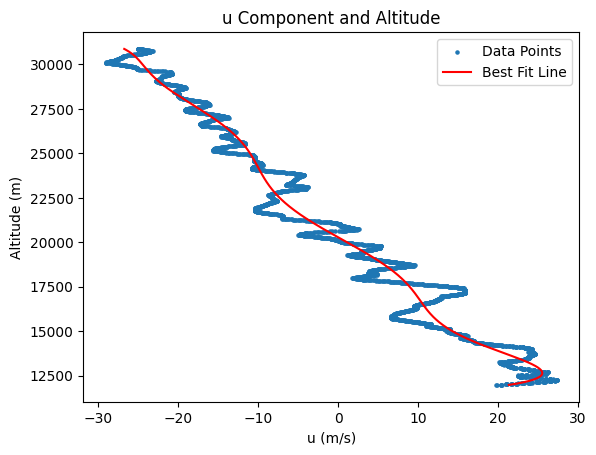

In [53]:
graph2d(strato_df, 'U','Alt', 8,'u (m/s)', 'Altitude (m)','u Component and Altitude (Stratosphere)',True)

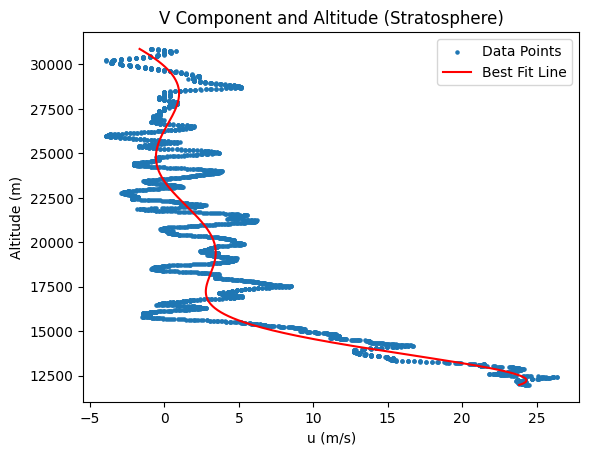

In [59]:
graph2d(strato_df, 'V','Alt', 8,'u (m/s)', 'Altitude (m)','V Component and Altitude (Stratosphere)',True)

/tmp/ipykernel_8236/1707157635.py:9: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = get_cmap('viridis')


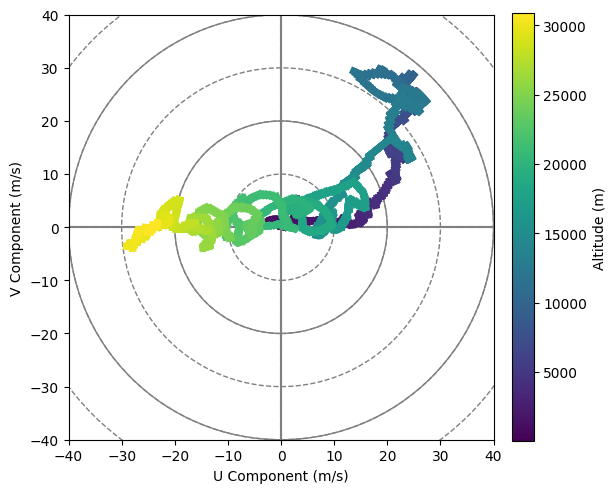

In [46]:
hodograph(40,5,profile_df,0)

/tmp/ipykernel_8236/1707157635.py:9: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = get_cmap('viridis')


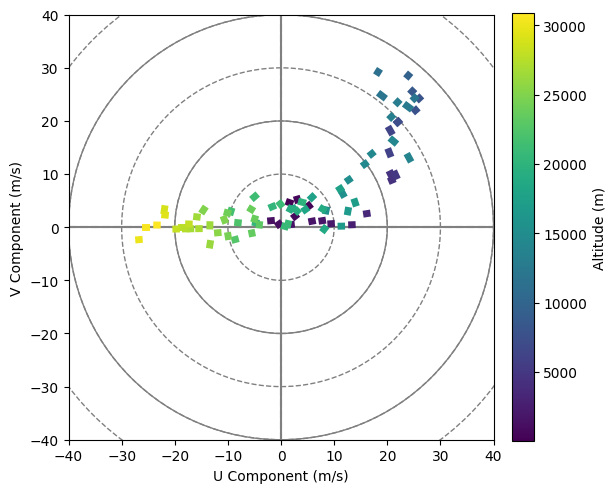

In [56]:
hodograph(40,5,profile_df,200)

/tmp/ipykernel_8236/1707157635.py:9: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = get_cmap('viridis')


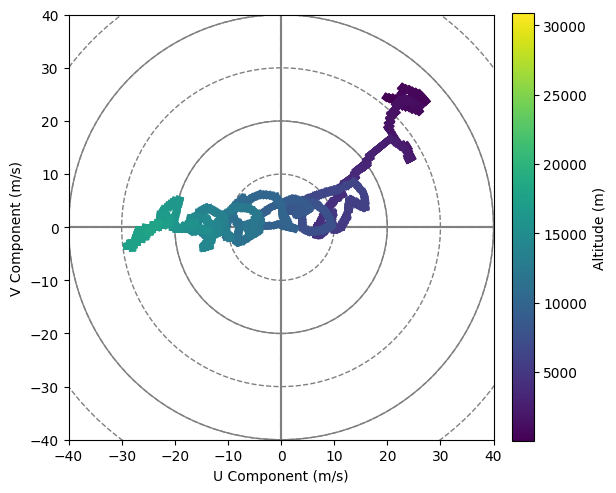

In [58]:
hodograph(40,5,stratoComps,0)